In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
from astropy.time import Time
import astropy.units as U
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
from natsort import natsorted
import math
from math import pi
from tqdm import tqdm
import time
from time import strftime, gmtime
import dask
os.environ['MPLCONFIGDIR'] = temp_dir.name

In [4]:
def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header



CLEAN SUM: 365.9314270019531, DIRTY SUM: -4526.849609375


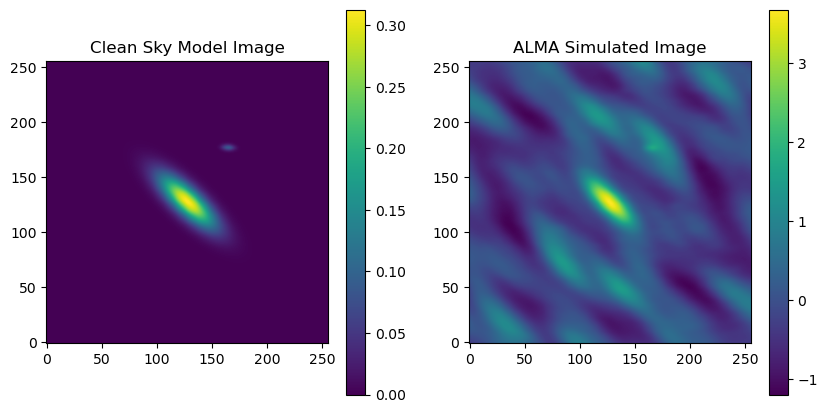

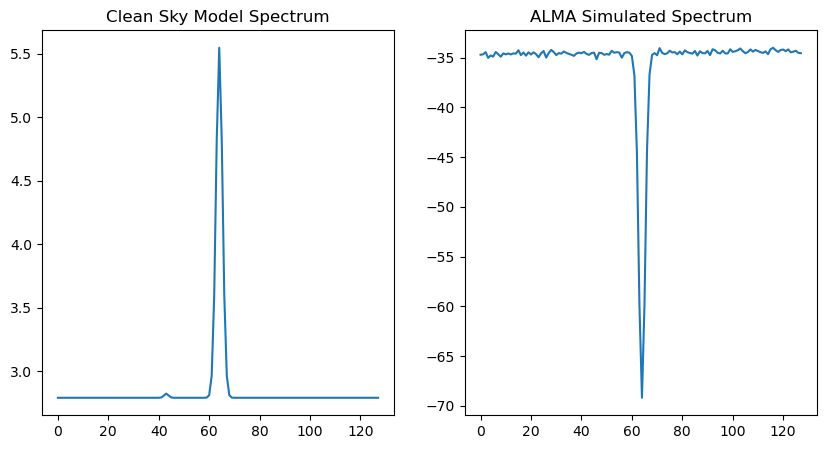

CLEAN SIMPLE : True, DIRTY SIMPLE : True
CLEAN BITPIX : -32, DIRTY BITPIX : -32
CLEAN NAXIS : 4, DIRTY NAXIS : 4
CLEAN NAXIS1 : 365, DIRTY NAXIS1 : 365
CLEAN NAXIS2 : 365, DIRTY NAXIS2 : 365
CLEAN NAXIS3 : 128, DIRTY NAXIS3 : 128
CLEAN NAXIS4 : 1, DIRTY NAXIS4 : 1
CLEAN EXTEND : True, DIRTY EXTEND : True
CLEAN BSCALE : 1.0, DIRTY BSCALE : 1.0
CLEAN BZERO : 0.0, DIRTY BZERO : 0.0
CLEAN BTYPE : Intensity, DIRTY BTYPE : Intensity
CLEAN OBJECT : , DIRTY OBJECT : sims_0.alma.cycle9.3.3_0
CLEAN BUNIT : Jy/pixel, DIRTY BUNIT : Jy/beam
CLEAN EQUINOX : 2000.0, DIRTY EQUINOX : 2000.0
CLEAN RADESYS : FK5, DIRTY RADESYS : FK5
CLEAN LONPOLE : 180.0, DIRTY LONPOLE : 180.0
CLEAN LATPOLE : -40.0, DIRTY LATPOLE : -40.0
CLEAN PC1_1 : 1.0, DIRTY PC1_1 : 1.0
CLEAN PC2_1 : 0.0, DIRTY PC2_1 : 0.0
CLEAN PC3_1 : 0.0, DIRTY PC3_1 : 0.0
CLEAN PC4_1 : 0.0, DIRTY PC4_1 : 0.0
CLEAN PC1_2 : 0.0, DIRTY PC1_2 : 0.0
CLEAN PC2_2 : 1.0, DIRTY PC2_2 : 1.0
CLEAN PC3_2 : 0.0, DIRTY PC3_2 : 0.0
CLEAN PC4_2 : 0.0, DIRTY PC4_

In [17]:
datadir = '/media/storage/sim'
clean, clean_header = load_fits(datadir + '/clean_cube_0.fits')
dirty, dirty_header = load_fits(datadir + '/dirty_cube_0.fits')
clean = clean[0, :, clean.shape[2]//2 - 128: clean.shape[2]//2 + 128, clean.shape[3]//2 - 128: clean.shape[3]//2 + 128]
dirty = dirty[0, :, dirty.shape[2]//2 - 128: dirty.shape[2]//2 + 128, dirty.shape[3]//2 - 128: dirty.shape[3]//2 + 128]
clean_image = np.sum(clean, axis=0)
dirty_image = np.sum(dirty, axis=0)
clean_spectrum = np.sum(clean, axis=(1, 2))
dirty_spectrum = np.sum(dirty, axis=(1, 2))
print('CLEAN SUM: {}, DIRTY SUM: {}'.format(np.sum(clean_image), np.sum(dirty_image)))


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(clean_image, origin='lower')
plt.colorbar(ax[0].imshow(clean_image, origin='lower'), ax=ax[0])
ax[1].imshow(dirty_image, origin='lower')
plt.colorbar(ax[1].imshow(dirty_image, origin='lower'), ax=ax[1])
ax[0].set_title('Clean Sky Model Image')
ax[1].set_title('ALMA Simulated Image')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(clean_spectrum)
ax[1].plot(dirty_spectrum)
ax[0].set_title('Clean Sky Model Spectrum')
ax[1].set_title('ALMA Simulated Spectrum')
plt.show()


for clean_key, clean_value, dirty_key, dirty_value in zip(clean_header.keys(), clean_header.values(), dirty_header.keys(), dirty_header.values()):
    print('CLEAN {} : {}, DIRTY {} : {}'.format(clean_key, clean_value, dirty_key, dirty_value))
